# **Machine Learning using Grammatical Evolution**
### Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Clone GRAPE repository***

In [2]:
import os.path

In [3]:
PATH = '/users/ranyahwigi/desktop/FYP/grape'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /users/ranyahwigi/desktop/FYP/grape/

grape directory already exists
/Users/ranyahwigi/Desktop/FYP/grape


In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [5]:
!pip install deap
!pip install numpy
!pip install -U imbalanced-learn

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math

### ***Preparing Data***

**Loading dataset**

In [6]:
# loading in the dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

**Extracting information on the data**

*Size of dataset*

In [7]:
# number of rows in dataset
number_of_samples = data['PatientID'].count()

**Dropping columns from dataset**

In [8]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [10]:
final_number_of_columns = len(data.columns)

**Train and test split**

In [11]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

Training (X,Y):	 (33625, 104) (33625,)
Test (X,Y):	 (14411, 104) (14411,)


**Check grammar file**

In [19]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|

**Setup grammar**

In [20]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar.bnf")

### ***Fitness Function***

In [21]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
    numerator = (TP+TN)
    denominator = (TP+TN+FP+FN)
    fitness = numerator / denominator

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [22]:
POPULATION_SIZE = 200
MAX_GENERATIONS = 100
P_CROSSOVER = 0.9
P_MUTATION = 0.6
ELITE_SIZE = round(0.1*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 10
MAX_INIT_TREE_DEPTH = 8
MIN_INIT_TREE_DEPTH = 2
MAX_TREE_DEPTH = 10
MAX_WRAPS = 0
CODON_SIZE = 320

**Creating DEAP toolbox**

In [23]:
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

toolbox.register("select", ge.selTournament, tournsize=10)

toolbox.register("mate", ge.crossover_onepoint)

toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [24]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std      	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.505106	0.0224232	0.429175	0.588788	0.428631    	64             	31.355    	120       	0             	4.26729        
1  	34     	0.499668	0.0259456	0.407257	0.568714	0.56894     	54             	33.02     	120       	0.00185919    	2.03529        
2  	20     	0.50266 	0.0265951	0.407257	0.567762	0.56894     	54             	37.98     	112       	0.00185418    	2.02964        
3  	8      	0.502431	0.0250545	0.407257	0.532996	0.56894     	54             	37.77     	112       	0.00192904    	2.2961         
4  	7      	0.501621	0.0261174	0.407257	0.55423 	0.56894     	54             	39.7      	112       	0.00176978    	2.19674        
5  	4      	0.502648	0.0269662	0.407257	0.575197	0.578447    	56             	37.965    	116       	0.00183415    	2.10898        
6  	7      	0.499444	0.0280707	0.407257	0.524372	0.578447    	56             	38.35

62 	2      	0.495431	0.0362535	0.376625	0.524372	0.603497    	38             	51.18     	108       	0.00176191    	2.409          
63 	3      	0.492969	0.0387801	0.376625	0.554677	0.603497    	38             	49.905    	114       	0.00176883    	2.10418        
64 	6      	0.495842	0.0376572	0.376625	0.560922	0.603497    	38             	46.34     	109       	0.00180197    	2.58616        
65 	3      	0.496144	0.0377078	0.376625	0.556104	0.603497    	38             	46.01     	111       	0.00180101    	2.54827        
66 	2      	0.49178 	0.0394025	0.376625	0.555807	0.603497    	38             	48.51     	114       	0.00174475    	2.25769        
67 	9      	0.49491 	0.039776 	0.376625	0.534275	0.603497    	38             	46.955    	128       	0.00178289    	2.10582        
68 	2      	0.494659	0.039298 	0.376625	0.536149	0.603497    	38             	44.995    	128       	0.00181103    	2.26329        
69 	3      	0.495805	0.0397041	0.376625	0.554558	0.603497    	38             	41.87

**Statistics**

In [25]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.505106,0.022423,0.429175,0.588788,0.428631,64,31.355,120,0.000000,4.267287
1,1,34,0.499668,0.025946,0.407257,0.568714,0.568940,54,33.020,120,0.001859,2.035290
2,2,20,0.502660,0.026595,0.407257,0.567762,0.568940,54,37.980,112,0.001854,2.029641
3,3,8,0.502431,0.025054,0.407257,0.532996,0.568940,54,37.770,112,0.001929,2.296097
4,4,7,0.501621,0.026117,0.407257,0.554230,0.568940,54,39.700,112,0.001770,2.196743
5,5,4,0.502648,0.026966,0.407257,0.575197,0.578447,56,37.965,116,0.001834,2.108985
6,6,7,0.499444,0.028071,0.407257,0.524372,0.578447,56,38.355,117,0.001814,2.264782
7,7,7,0.502113,0.027935,0.407257,0.544565,0.578447,56,39.690,118,0.003318,2.415957
8,8,5,0.499341,0.029605,0.407257,0.533978,0.578447,56,38.495,117,0.001800,2.352162
9,9,12,0.500079,0.029259,0.407257,0.530944,0.578447,56,38.975,123,0.002071,2.851345


**Best individual**

In [26]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
add(mul(sub(add(x[101],x[10]),sub(44.15,pdiv(x[57],x[103]))),x[47]),neg(32.55))

Training Fitness:  0.6095762081784387

Depth:  7

Length of the genome:  33

Used portion of the genome: 0.67



Calculating predictions

In [13]:
x = X_test
predictions = add(mul(sub(add(x[101],x[10]),sub(44.15,pdiv(x[57],x[103]))),x[47]),neg(32.55))
print(predictions)

[ -73.86040671 4794.50424941  297.75098394 ...  589.67131481 1846.03988864
   49.75394985]


In [14]:
Y_prediction_class= [1 if predictions[i] > 0 else 0 for i in range(len(predictions))]
print(Counter(Y_prediction_class))

Counter({1: 11553, 0: 2858})


Calculating Confusion Matrix

In [16]:
TP, FN, TN, FP = 0, 0, 0, 0
for x, y in zip(Y_test, Y_prediction_class):
  # 0 = no cancer, 1 = cancer
  if x == 0:
    if y == 0:
      TN = TN + 1
    else:
      FP = FP + 1
  elif x == 1:
    if y == 1:
      TP = TP + 1
    else:
      FN = FN + 1

Accuracy

In [17]:
numerator = (TP+TN)
denominator = (TP+TN+FP+FN)
accuracy = numerator / denominator
accuracy

0.609187426271598

True Positive Rate

In [18]:
TPR = TP/(TP+FN)
TPR

0.9108952116585705

True Negative Rate

In [19]:
TNR = TN/(TN+FP)
TNR

0.3075215098529004

False Positive Rate

In [20]:
FPR = FP/(FP+TN)
FPR

0.6924784901470996

False Negative Rate

In [21]:
FNR = FN/(FN+TP)
FNR

0.08910478834142957

Area Under the Curve

In [22]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, Y_prediction_class)
auc

0.6092083607557355

**Best individuals plots**

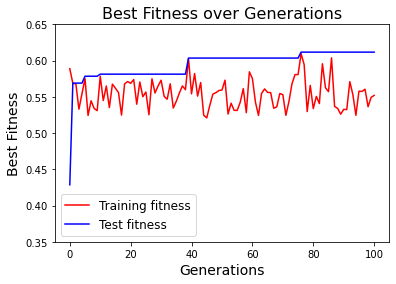

In [58]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.yticks(np.arange(0.35, 0.67, 0.05))
plt.show()

**Average fitness plot**

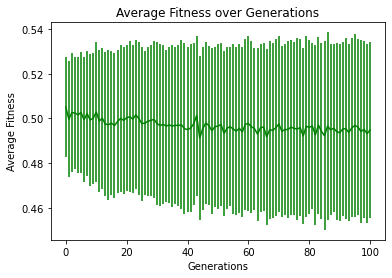

In [59]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

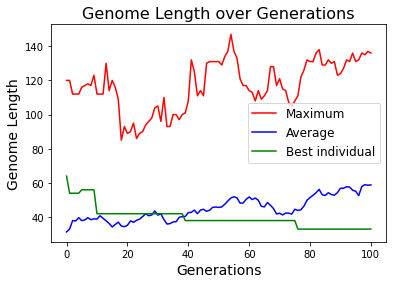

In [60]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()